In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KDTree
from sklearn.model_selection import KFold
from sklearn import metrics

# get complexs

In [2]:
# human_all = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\complexes\9606.tsv',sep='\t')
# print(human_all['Recommended name'].tolist())

# complexs = dict()
# for i in range(len(human_all)):
#     complex_name = human_all.iloc[i]['#Complex ac']
#     names = human_all.iloc[i]['Recommended name']
#     if ',' in names:
#         name_list = names.split(',')
#         for name in name_list:
#             if '-' in name:
#                 par_list = name.split('-')
#                 if len(set(par_list)) > 1:
#                     if all(element in protein_names and len(element)>1 for element in par_list):
#                         # print(par_list)
#                         complexs[complex_name] = par_list
                            
#     elif '-' in names:
#         name = names.split(' ')[0]
#         par_list = name.split('-')
#         if len(set(par_list)) > 1:
#             if all(element in protein_names and len(element)>1 for element in par_list):
#                 # print(par_list)
#                 complexs[complex_name] = par_list

In [2]:
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_aliases2stringId.pkl', 'rb') as file:
    aliases2stringId = pickle.load(file)
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_name2stringId.pkl', 'rb') as file:
    name2stringId = pickle.load(file)
def convert_stringId(alias):
    try:
        stringId = name2stringId[alias]
    except:
        #print(alias, 'can\'t be converted by name2stringId! Now trying aliases2stringId.')
        try:
            stringId = aliases2stringId[alias]
        except:
            #print(alias, 'can\'t be converted by aliases2stringId! Now return None.')
            stringId = None
    #print(alias, stringId)
    return stringId

In [3]:
protein_names = list(aliases2stringId.keys())
protein_names.extend(list(name2stringId.keys()))

In [115]:
file_path = r'D:\study\thesis\project\HBDM-main\data\complexes\CORUM-Human-Complexes_r.txt'

# Initialize an empty dictionary to store the data
data_dict = {}

# Read the text file and populate the dictionary
with open(file_path, 'r') as file:
    for line_index, line_content in enumerate(file, start=1):
        # Enumerate starts index from 1
        values = line_content.strip().split('\t')  # Assuming values are separated by whitespace
        uniques = list(set(values)&set(protein_names))
        if len(uniques) > 1:
            data_dict[line_index] = uniques
file_path = r'D:\study\thesis\project\HBDM-main\data\complexes\human_complexes.pkl'

# Serialize and save the Tensor to the file
with open(file_path, 'wb') as file:
    pickle.dump(data_dict, file)
# Close the file
file.close()

In [4]:
with open(r'D:\study\thesis\project\HBDM-main\data\complexes\human_complexes.pkl', 'rb') as file:
    data_dict = pickle.load(file)

In [5]:
len(data_dict)

2640

In [6]:
complexs = dict()

for key, value in data_dict.items():
    length = len(value)
    if length <= 7:
        complexs[key] = value
len(complexs)

2350

In [7]:

with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_index.pkl', 'rb') as file:
    ppi_index = pickle.load(file)
node2string = {value: key for key, value in ppi_index.items()}

humans = set(ppi_index.keys())

complexs_id = dict()

for complex_name in complexs:
    # folder_path = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/'+complex_name
    # os.mkdir(folder_path)
    group_node = []
    for gene in complexs[complex_name]:
        if gene in protein_names:
            stringid = convert_stringId(gene)
            if stringid in humans:
                node = ppi_index[stringid]
                group_node.append(node)
    if len(set(group_node)) != 1:
        complexs_id[complex_name] = group_node

In [8]:
len(complexs_id)

2350

In [10]:
file_path = r'D:\study\thesis\project\HBDM-main\data\complexes\human_complexes_node.pkl'
# Serialize and save the Tensor to the file
with open(file_path, 'wb') as file:
    pickle.dump(complexs_id, file)
# Close the file
file.close()

# get node embeddings

In [2]:

name = 'Dataset-ppi--RE-True--W-1--Epochs-15000--D-[4]--RH-25--LR-0.1--LP-False--CUDA-True'
# name = 'NB_Dataset-ppi--RE-True--W-2--Epochs-15000--D-4--RH-25--LR-0.1--LP-False--CUDA-True'
root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'+name
dataset = 'n_ppi_g'


### get node and 1d,2d
file_path_d = root+'/latent.pkl'
with open(file_path_d, 'rb') as file:
    node_rep = pickle.load(file)

# tensor = loaded_tensor.cpu()
# node_rep = tensor.detach().numpy()

node_rep = np.array(node_rep)
df_latent = pd.DataFrame()
for d in range(node_rep.shape[1]):
    col_name = str(d+1)+'d'
    df_latent[col_name] = node_rep.T[d]
df_latent['node'] = df_latent.index

df = df_latent
df.head(3)

,1d,2d,3d,4d,node
0,0.058722,0.050162,2.286775,-2.781419,0
1,-1.222360,-1.755359,1.424640,-4.508383,1
2,-0.772616,-0.142375,-0.559201,-1.309009,2


In [17]:
with open(r'D:\study\thesis\project\HBDM-main\data\disease\cad_node.pkl', 'rb') as file:
    group_node = pickle.load(file)

# k_values = [10,20,30,40,50]
k_values = [3,5,10,25,50,75,100]    
#################################################################################################
# pathways_id = dict(sorted(pathways_id.items(), key=lambda item: item[1], reverse=True)[:10])
outlier = []
#################################################################################################

# for each eomplex, get precision and recall values of varing k
roc_ks = []
pr_ks = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for k in k_values:
    k+=1
    results = []

    # Build a k-d tree from the points
    kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
    for train_index, test_index in kf.split(group_node):
        train_nodes = [group_node[i] for i in train_index]
        test_nodes = [group_node[i] for i in test_index]
        start = []
        dist = []
        neighbor = []

        for i in train_nodes:
            given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
            # Perform a k-NN search to find the k+1 nearest neighbors
            distances, indices = kdtree.query(given_point, k=k)
            start += (k-1)*[i]
            dist += distances.reshape(-1).tolist()[1:]
            neighbor += indices.reshape(-1).tolist()[1:]


        neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
        neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(train_nodes)]
        predict_df = neighbor_df['neighbor'].value_counts().to_frame()
        predict_df.reset_index(inplace=True)
        predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
        predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in test_nodes else 0, axis=1)
        if len(predict_df[predict_df['true']==1])==0:
            results.append([0, 0])
        else:
            predicted_positives = predict_df['count']
            true_positives = predict_df['true']
            precision, recall, thresholds = metrics.precision_recall_curve(true_positives,predicted_positives)
            roc,pr= metrics.roc_auc_score(true_positives,predicted_positives),metrics.auc(recall,precision)
            results.append([roc,pr])
    results = np.array(results)
    roc = np.mean(results[:, 0])
    pr = np.mean(results[:, 1])
    roc_ks.append(roc)
    pr_ks.append(pr)

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
y_true = true_positives
y_est = predicted_positives

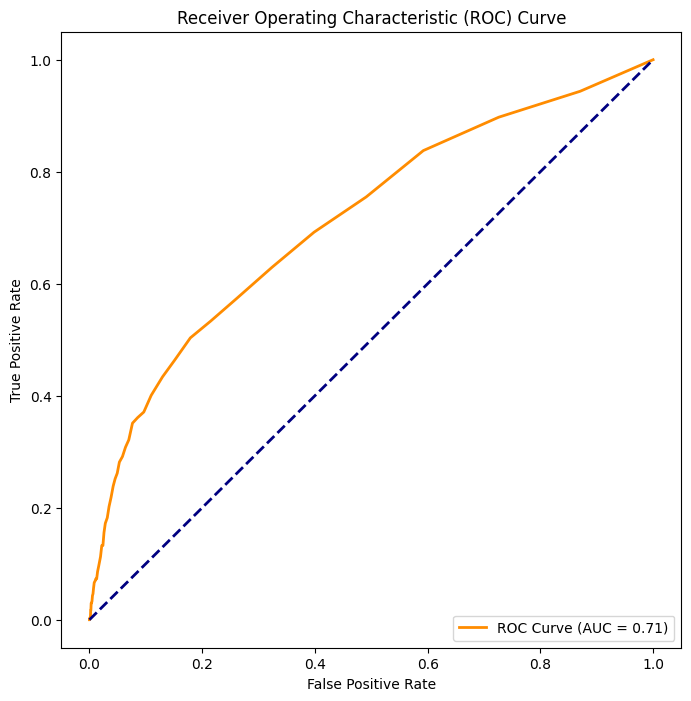

In [26]:
# Assuming y_est contains predicted probabilities or scores and y_true contains true labels (0 or 1)
fpr, tpr, thresholds = roc_curve(y_true, y_est)
roc_auc = roc_auc_score(y_true, y_est)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
youden_index = np.argmax(tpr - fpr)
best_threshold_youden = thresholds[youden_index]
len(predict_df['count']>best_threshold_youden)

16050

In [29]:

dist_to_top_left = np.sqrt((1 - tpr)**2 + fpr**2)
best_threshold_dist = thresholds[np.argmin(dist_to_top_left)]
len(predict_df['count']>best_threshold_dist)

16050

In [31]:
f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
best_threshold_f1 = thresholds[np.argmax(f1_scores)]
precision = tpr / (tpr + fpr)
recall = tpr
# Choose threshold based on precision or recall depending on your preference
best_threshold_precision = thresholds[np.argmax(precision)]
best_threshold_recall = thresholds[np.argmax(recall)]
len(predict_df['count']>best_threshold_dist)

C:\Users\ZZY\AppData\Local\Temp\ipykernel_47380\3711620450.py:3: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


16050

In [5]:
roc_ks

[0.700253053116733,
 0.7244275095113006,
 0.7287646485228534,
 0.7306287112783203,
 0.7315451680388876,
 0.7327138623426055,
 0.732629712252806,
 0.7332312562639562]

In [19]:
roc_ks

[0.5986919178746968,
 0.6355203415388336,
 0.6587366574219891,
 0.6925406998404995,
 0.700253053116733,
 0.7168298709370138,
 0.7244275095113006]

In [20]:
pr_ks

[0.11046662693555982,
 0.09885677776379256,
 0.0876741210708972,
 0.08556203549883064,
 0.07158059618548271,
 0.06863561045722857,
 0.06830485061426644]

In [6]:
pr_ks

[0.02011777276241538,
 0.019376569237169818,
 0.018479382474844853,
 0.01885894721620541,
 0.01805348025321794]

In [104]:
disease_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\disease\Coronary_artery_disease.tsv',sep='\t')
names = protein_names
humans = set(ppi_index.keys())

group_node = []
for gene in disease_df['Gene']:
    if gene in names:
        stringid = convert_stringId(gene)
        if stringid in humans:
            node = ppi_index[stringid]
            group_node.append(node)

In [94]:
len(group_node)

1535

In [117]:
# Define your range of k values and leaf_size values
k_values = [3,5, 10,20,50,100]

# Split your data into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    k+=1
    precision_scores = []
    coverage_scores = []
    random_precision_scores = []
    random_coverage_scores = []

    # Build a k-d tree from the points
    kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
    for train_index, test_index in kf.split(group_node):
        train_nodes = [group_node[i] for i in train_index]
        test_nodes = [group_node[i] for i in test_index]

        start = []
        dist = []
        neighbor = []
        random_nodes = []
        for i in train_nodes:
            given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
            # Perform a k-NN search to find the k+1 nearest neighbors
            distances, indices = kdtree.query(given_point, k=k)
            start += (k-1)*[i]
            dist += distances.reshape(-1).tolist()[1:]
            neighbor += indices.reshape(-1).tolist()[1:]

            random_nodes += random.sample(list(set(df['node'].tolist())-set(train_nodes)), (k-1))

        neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
        cover_df = neighbor_df[neighbor_df['neighbor'].isin(test_nodes)]
        # if len(cover_df) == 0:
        #     print(test_nodes)
        # Append precision and coverage scores to lists
        precision_scores.append(len(cover_df) / len(neighbor_df))
        coverage_scores.append(len(cover_df['neighbor'].unique()) / len(test_nodes))
        
        ############################ random
        random_cover = []
        for j in random_nodes:
            if j in test_nodes:
                random_cover.append(j)

    # Calculate the average precision and coverage scores for the current k and leaf_size
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_coverage = sum(coverage_scores) / len(coverage_scores)
    print(f"k={k-1}, leaf_size={20}",'\t',"Average Precision:", avg_precision,'\t',"Average Coverage:", avg_coverage)



ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=2.

In [ ]:
k=3, leaf_size=20 	 Average Precision: 0.042996742671009766 	 Average Coverage: 0.3400651465798045
k=5, leaf_size=20 	 Average Precision: 0.04175895765472313 	 Average Coverage: 0.4410423452768729
k=10, leaf_size=20 	 Average Precision: 0.04001628664495114 	 Average Coverage: 0.606514657980456
k=20, leaf_size=20 	 Average Precision: 0.03874592833876221 	 Average Coverage: 0.7615635179153094
k=50, leaf_size=20 	 Average Precision: 0.03743648208469055 	 Average Coverage: 0.9159609120521172
k=100, leaf_size=20 	 Average Precision: 0.036030944625407166 	 Average Coverage: 0.9726384364820847

In [118]:
# Define your range of k values and leaf_size values
k_values = [3,5,10,20,50,100]

precision_complexs= []
coverages_complexs=[]

for complex_name in complexs_id:
    # output_file = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/'+complex_name+'/'+name+".txt"
    group_node = complexs_id[complex_name]

    precision_ks = []
    coverage_ks = []

    ## get final df: node, cluster, 1d, 2d, label
    df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
    # Set the index to match the values in column 'node'
    df = df.set_index('node')
    # Reset the index to its default integer index
    df = df.reset_index()    
    # with open(output_file, "w") as f:
    for k in k_values:
        k+=1

        kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)

        precision = []
        coverage = []
        for i in group_node:
            true_pre = []
            test_nodes = list(set(group_node)-set([i]))
            given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
            # Perform a k-NN search to find the k+1 nearest neighbors
            distances, indices = kdtree.query(given_point, k=k)
            # start += (k-1)*[i]
            # dist += distances.reshape(-1).tolist()[1:]
            neighbor = indices.reshape(-1).tolist()[1:]

            for j in neighbor:
                if j in test_nodes:
                    true_pre.append(j)
            precision.append(len(true_pre)/len(neighbor))
            coverage.append(len(set(true_pre))/len(test_nodes))
        precision_ks.append(sum(precision)/len(precision))
        coverage_ks.append(sum(coverage)/len(coverage))
    precision_complexs.append(precision_ks)
    coverages_complexs.append(coverage_ks)
            # print(f'k- {k-1} precision: {sum(precision)/len(precision)} coverage: {sum(coverage)/len(coverage)}', file=f)
    # f.write()

In [119]:
knn_complexs = pd.DataFrame(precision_complexs, columns=['p_3','p_5','p_10', 'p_20', 'p_50', 'p_100'])
for i, col in enumerate(['c_3','c_5','c_10', 'c_20', 'c_50', 'c_100']):
    knn_complexs[col] = np.array(coverages_complexs).T[i]
path = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/complexes/small/'+dataset+'.csv'
knn_complexs.to_csv(path,index=False)

In [120]:
knn_complexs.mean()

p_3      0.050899
p_5      0.037958
p_10     0.026493
p_20     0.014162
p_50     0.008507
p_100    0.005385
c_3      0.132466
c_5      0.166667
c_10     0.218690
c_20     0.235067
c_50     0.357900
c_100    0.446050
dtype: float64

In [65]:
knn_complexs.mean()

p_3      0.057803
p_5      0.038247
p_10     0.020039
p_20     0.011705
p_50     0.005241
p_100    0.002943
c_3      0.138728
c_5      0.154624
c_10     0.161850
c_20     0.194605
c_50     0.219653
c_100    0.239403
dtype: float64

# shortest path

In [19]:
import networkx as nx

In [76]:
local_stringdb = 'D:/study/thesis/project/HBDM-main/data/nn_data/stringdb/'
string_score_transform = lambda x: -np.log(x/1000)
                
network = pd.read_csv(local_stringdb+'9606.protein.physical.links.detailed.v12.0.txt', sep=' ', header=0).convert_dtypes().replace(0, float('nan'))

bins = [149, 199, 299, 399, 499, 599, 699, 799, 899, 999]
labels = [9, 8, 7, 6, 5, 4, 3, 2, 1]
# labels = [1,2,3,4,5,6,7,8,9]

# Use pd.cut to categorize the data into levels
network['weight_10'] = pd.cut(network['combined_score'], bins=bins, labels=labels, include_lowest=True)


# network['combined_score'] = network['combined_score'].apply(string_score_transform)


In [79]:
network['node1'] = network['protein1'].map(ppi_index)
network['node2'] = network['protein2'].map(ppi_index)

In [80]:
network.head(3)

,protein1,protein2,experimental,database,textmining,combined_score,weight_10,node1,node2
0,9606.ENSP00000000233,9606.ENSP00000257770,312,<NA>,<NA>,311,7,0,1914
1,9606.ENSP00000000233,9606.ENSP00000226004,162,<NA>,<NA>,161,9,0,776
2,9606.ENSP00000000233,9606.ENSP00000434442,<NA>,500,<NA>,499,6,0,15878


In [81]:
G = nx.from_pandas_edgelist(network, source='node1', target='node2', edge_attr='weight_10', create_using=nx.Graph)

In [85]:
# Define your range of k values and leaf_size values
k_values = [3,5,10,20,50,100]

precision_complexs= []
coverages_complexs=[]

for complex_name in complexs_id:
    # output_file = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/'+complex_name+'/'+name+".txt"
    group_node = complexs_id[complex_name]
    precision_ks = []
    coverage_ks = []
    for i in group_node:
        precision = []
        coverage = []

        true_pre = []
        test_nodes = list(set(group_node)-set([i]))
        source_node = i
        shortest_paths = nx.single_source_dijkstra_path_length(G, source_node, weight='weight_10')
        sorted_nodes = sorted(shortest_paths.items(), key=lambda x: x[1])
        for k in k_values:
            neighbor = [node for node, distance in sorted_nodes[:k]]
            for j in neighbor:
                if j in test_nodes:
                    true_pre.append(j)
            precision.append(len(true_pre)/len(neighbor))
            coverage.append(len(set(true_pre))/len(test_nodes))
        
        precision_ks.append(precision)
        coverage_ks.append(coverage)

    precision_complexs.append(np.mean(np.array(precision_ks), axis=0))
    coverages_complexs.append(np.mean(np.array(coverage_ks), axis=0))

In [86]:
save_data = [precision_complexs,coverages_complexs]
with open('D:/study/thesis/project/HBDM-main/ppi_results/test_results/complexes/small/sp_10.pkl', 'wb') as file:
    pickle.dump(save_data, file)

In [87]:
np.round(np.mean(precision_complexs, axis=0), 2)

array([0.15, 0.22, 0.19, 0.15, 0.08, 0.05])

In [88]:
np.round(np.mean(coverages_complexs, axis=0), 2)

array([0.41, 0.57, 0.75, 0.85, 0.9 , 0.91])

In [94]:
source_node=2759
# Calculate shortest paths using Dijkstra's algorithm
shortest_paths = nx.single_source_dijkstra_path_length(G, source_node, weight='combined_score')
sorted_nodes = sorted(shortest_paths.items(), key=lambda x: x[1])
shortest_paths2 = nx.single_source_dijkstra_path_length(G, source_node)




In [96]:

top_k_nodes = [node for node, distance in sorted_nodes[:5]]
top_k_nodes

[2759, 3125, 1702, 12796, 15274]

# check results

In [30]:
knn_binary = pd.read_csv(r'D:\study\thesis\project\HBDM-main\ppi_results\test_results\complexes\small\ppi_binary.csv')
knn_10 = pd.read_csv(r'D:\study\thesis\project\HBDM-main\ppi_results\test_results\complexes\small\ppi_10.csv')
knn_g = pd.read_csv(r'D:\study\thesis\project\HBDM-main\ppi_results\test_results\complexes\small\ppi_g.csv')

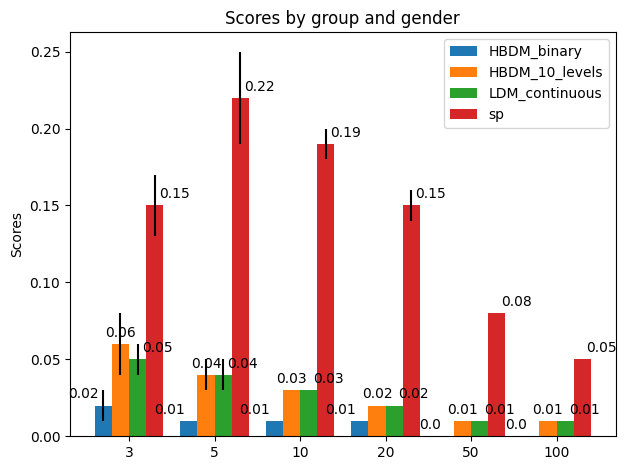

In [90]:
# cols = ['c_3','c_5','c_10', 'c_20', 'c_50', 'c_100']
# title = 'coverage'

cols = ['p_3','p_5','p_10', 'p_20', 'p_50', 'p_100']
title = 'precision'
means = []
vars = []
for subdf in [knn_binary,knn_10,knn_g]:
    subdf = subdf[cols]
    mean_values = subdf.mean().round(2)
    variance_values = subdf.var().round(2)
    means.append(list(mean_values))
    vars.append(list(variance_values))

# Extract individual data arrays
b_means, b_std = means[0], vars[0]
w_means, w_std = means[1], vars[1]
g_means, g_std = means[2], vars[2]
s_means, s_std = np.round(np.mean(precision_complexs, axis=0), 2), np.round(np.var(precision_complexs, axis=0), 2)
# s_means, s_std = np.round(np.mean(coverages_complexs, axis=0), 2), np.round(np.var(coverages_complexs, axis=0), 2)

ind = np.arange(len(b_means))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - 1.5 * width, b_means, width, yerr=b_std, label='HBDM_binary')
rects2 = ax.bar(ind - 0.5 * width, w_means, width, yerr=w_std, label='HBDM_10_levels')
rects3 = ax.bar(ind + 0.5 * width, g_means, width, yerr=g_std, label='LDM_continuous')
rects4 = ax.bar(ind + 1.5 * width, s_means, width, yerr=s_std, label='sp')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind)
ax.set_xticklabels(('3','5', '10', '20', '50', '100'))
ax.legend()

def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos] * 3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")
autolabel(rects4, "right")

fig.tight_layout()
plt.show()


In [70]:


def get_results(cols,title):
    means = []
    vars = []
    for subdf in [knn_binary,knn_10,knn_g]:
        subdf = subdf[cols]
        mean_values = subdf.mean().round(2)
        variance_values = subdf.var().round(2)
        means.append(list(mean_values))
        vars.append(list(variance_values))

    b_means, b_std = means[0], vars[0]
    w_means, w_std = means[1], vars[1]
    g_means, g_std = means[2], vars[2]

    ind = np.arange(len(b_means))  # the x locations for the groups
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width, b_means, width, yerr=b_std, label='binary')
    rects2 = ax.bar(ind, w_means, width, yerr=w_std, label='10_levels')
    rects3 = ax.bar(ind + width, g_means, width, yerr=g_std, label='continuous')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel(title)
    ax.set_title(title+' for k-neighbors')
    ax.set_xticks(ind)
    ax.set_xticklabels(('3', '5', '10', '20', '50', '100'))
    ax.legend()


    def autolabel(rects, xpos='center'):
        """
        Attach a text label above each bar in *rects*, displaying its height.

        *xpos* indicates which side to place the text w.r.t. the center of
        the bar. It can be one of the following {'center', 'right', 'left'}.
        """

        ha = {'center': 'center', 'right': 'left', 'left': 'right'}
        offset = {'center': 0, 'right': 1, 'left': -1}

        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(offset[xpos] * 3, 3),  # use 3 points offset
                        textcoords="offset points",  # in both directions
                        ha=ha[xpos], va='bottom')


    autolabel(rects1, "left")
    autolabel(rects2, "center")
    autolabel(rects3, "right")

    fig.tight_layout()

    plt.show()

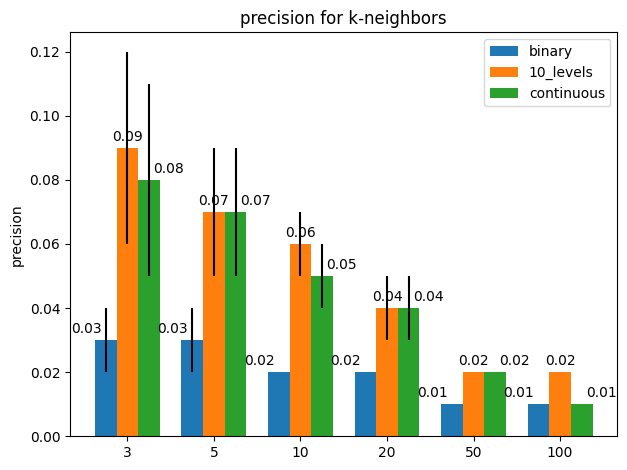

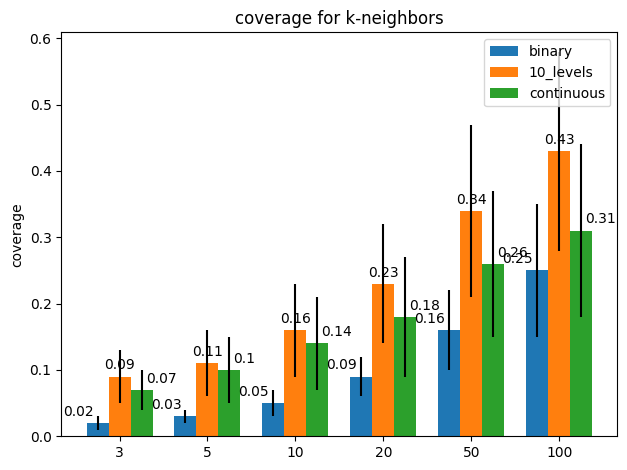

In [71]:
get_results(['p_3','p_5','p_10', 'p_20', 'p_50', 'p_100'],'precision')
get_results(['c_3','c_5','c_10', 'c_20', 'c_50', 'c_100'],'coverage')